[영화추천 EDA](https://www.kaggle.com/rounakbanik/the-story-of-film/)

![nn](https://media.giphy.com/media/3ohhwDMC187JqL69DG/giphy.gif)

이 노트북에서는 데이터를 활용해 통찰력을 얻으려한다. 이곳에서  TMDB에서 수집한 메타데이터를 포함해 약 4599편의 영화 데이터 세트를 가지고 있는데, 이 데이터를 통해 평소 영화에 대해 가지고 있는 다양한 궁금증을 풀어보도록 할 것이다. 

여기서는 다음을 시도하고 구축할 것이다.
* 특정 영화의 수익을 어느 정도 예측할 수 있는 **회귀**
* 영화의 흥행 여부를 구분하는 **분류**

# 라이브러리 및 데이터 불러오기

In [223]:
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor #(선행) conda install py-xgboos
from wordcloud import WordCloud, STOPWORDS

import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings 
warnings.filterwarnings('ignore')
# plotly.tools.wet_credentials_file(username='rounakbanik')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [224]:
df = pd.read_csv('movies_metadata.csv')
df.head().T

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


# 데이터 이해
---
위 데이터 세트는 TMDB API를 통해 얻었다. 이 데이터 세트에서 사용할 수 있는 영화는 27,000명의 사용자가 제작한 45,000편의 영화에 대해 2,600만 건의 시청률로 구성된 MoviesLens Letter Full Dataset에 나열된 영화와 일치한다.  
이제 우리가 사용할 수 있는 기능을 살펴보자.

In [225]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

* adult : 영화 등급이 X-등급인지 성인용인지 나타낸다.
* belongs_to_collection : 영화 시리즈에 대한 정보를 제공한다. 
* budget : 영화 예산(💲)
* genres : 영화관련 장르
* homepage : 영화의 공식 홈페이지
* id : 영화 ID
* imdb_id : 영화의 IMDB Id
* original_language : 영화가 촬영된 언어
* original_title : 영화 원제
* overview : 영화 개요
* popularity : TMDB에서 할당한 인기 점수
* poster_path : 포스터 이미지 URL
* production_companies : 영화 제작에 관여한 제작사 명단
* production_countries : 영화가 촬영/제작된 나라들 목록
* release_date : 영화 극장 개봉일
* revenue : 영화 총 수익
* runtime : 영화 상영 시간
* spoken_languages : 영화 더빙 목록
* status : 영화 상태(개봉 예정, 발표, 상영)
* tagline : 영화 태그라인
* title : 영화 공식 제목
* viedo : TMDB를 사용하는 영화의 비디오가 있는지 여부 표시
* vote_average : 영화 평균 평점
* vote_count : TMDB에서 집계한 사용자의 투표 수

In [226]:
df.shape

(45466, 24)

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

총 45,466편의 영화와 24개의 변수가 있다. 대부분의 변수는 홈페이지와 태그라인을 제외하고 결측치가 거의 없다. 다음 섹션에서는 분석에 적합한 형태로 이 데이터 집합을 정리하겠다.

# Data Wrangling
---
원본 데이터는 JSON파일임으로 이를 pandas를 통해 쉽게 로드할 수 있는 DataFrame 변환으로 변환하였다.  
현재 가지고 있는 데이터는 비교적 깨끗한 데이터이나 변수에 대해 더 분석하기 위해서는 적합한 형태로 변환해야 한다. 

In [228]:
df = df.drop('imdb_id', 1)

In [229]:
df[df['original_title'] != df['title']][['title','original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


원제목은 영화가 촬영된 모국어로 표기되어 있다. 이번 분석에서는 번역된 이름을 사용하는 것을 선호하기 때문에 원본 제목을 삭제할 것이다.  
(외국 영화 여부는 언어적 특성을 통해 추론 가능하기에 가시적 정보가 손실될 일은 없을 것으로 보인다.)

In [230]:
df = df.drop('original_title', 1)

In [231]:
df[df['revenue'] == 0].shape

(38052, 22)

In [232]:
df['revenue'] = df['revenue'].replace(0, np.nan)

In [233]:
# budget의 결측치를 나타내기 위해 0을 np.nan으로 변환한다.\
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')  # errors='coerce'없는 값은 NaN처리
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(36576, 22)

특정 질문에 답하기 위한 두가지 변수 생성
* **year** : 영화가 개봉된 해
* **return** : 예산(revenue) 대비 수익(budget)비율

**return** 변수는 영화의 재정적 성공을 나타냄으로 통찰력 있는 변수라 할 수 있다. 현재, 우리의 데이터는 1억 달러를 벌어들인 2억 달러의 예산 영화가 20만 달러의 예산 영화보다 더 나은지 판단할 수 없을 것이다. **return** 변수는 그 정보를 캡처할 수 있을 것이다.


수익 가치 > 1은 이익을 나타내는 반면 수익 가치 < 1은 손실을 나타낼 것이다.

In [234]:
df['return'] = df['revenue']/df['budget']
df[df['return'].isnull()].shape

(40085, 23)

In [235]:
df['year'] = pd.to_datetime(df['release_date'], errors = 'coerce').apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)

In [236]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [237]:
# 극소수의 변수만 포함함으로 삭제
df = df.drop('adult',1)

# EDA

## Title and Overview Wordclouds
영화 제목과 광고에서 자주 등장하는 단어들이 있는지 확인해본다.

In [238]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [239]:
title_corpus = ' '.join(df['title'])
overivew_corpus = ' '.join(df['overview'])

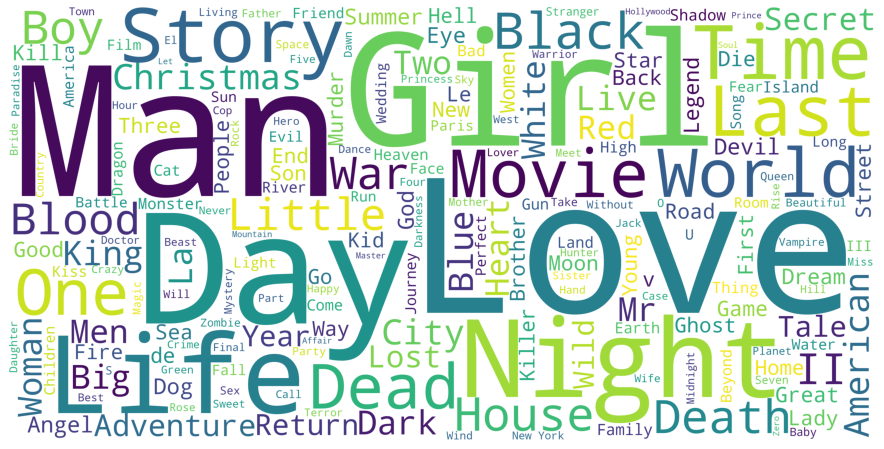

In [240]:
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

사랑이라는 단어는 영화 제목에서 가장 일반적으로 사용되는 단어이다. 나는 이것이 영화에서 로맨스의 유비쿼터스 존재에 대한 아이디어를 꽤 잘 요약한다고 생각한다.

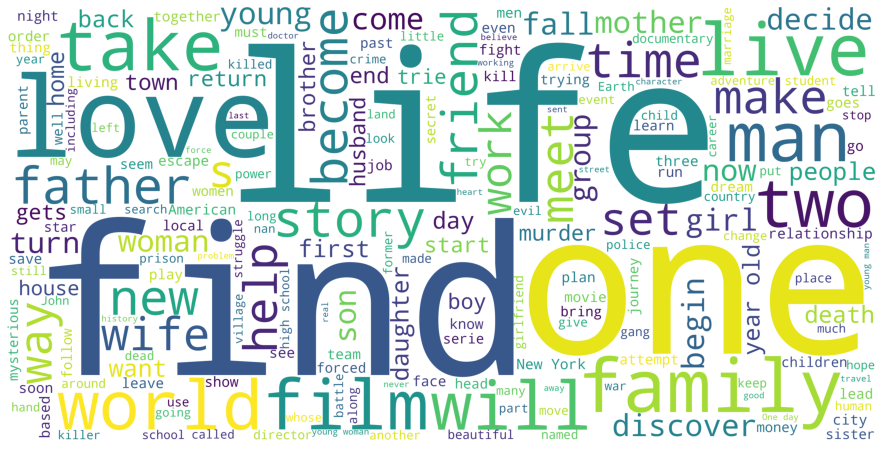

In [241]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white', height=2000, width = 4000).generate(overivew_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

인생은 영화 제목에서 가장 일반적으로 사용되는 단어이다. 원 앤 파인드는 영화 광고에서도 인기가 있다. 사랑, 남자와 소녀와 함께, 이 워드클라우드는 우리에게 영화에서 가장 인기 있는 주제에 대한 꽤 좋은 아이디어를 준다.

## Production Countries
미국과 영국의 영화 촬영을 위한 가장 인기 있는 목적지 역할을 하는지 보는 것은 흥미로울 것이다.

In [242]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [243]:
s = df.apply(lambda x : pd.Series(x['production_countries']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [244]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis = 1)
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [245]:
con_df = con_df[con_df['country'] != 'United States of America']

In [246]:
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

대체로 인기 있는 장소는 미국, 영국, 프랑스, 독일, 이탈리아이며 그 외 아시아 국가에서는 일본, 인도가 있다. 

## Franchise Movies

In [247]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x : x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [248]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue':['mean','sum','count']}).reset_index()

### 수입 상위 프랜차이즈 영화

In [249]:
fran_pivot.sort_values('sum', ascending = False).head(10)

,belongs_to_collection,count,mean,sum
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
646,James Bond Collection,26,2.733450e+08,7.106970e+09
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
1550,Transformers Collection,5,8.732202e+08,4.366101e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
1491,The Twilight Collection,5,6.684215e+08,3.342107e+09
610,Ice Age Collection,5,6.433417e+08,3.216709e+09
666,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


### 가장 성공적인 영화 프랜차이즈 (평균 총)

우리는 영화 프랜차이즈의 성공을 측정하기 위해 영화당 평균 총액을 사용할 것이다. 그러나, 이것은 이 데이터셋의 수익이 인플레이션에 맞게 조정되지 않았기 때문에 그다지 강력한 지표가 아니다. 따라서, 수익 통계는 최근에 프랜차이즈를 강력히 선호하는 경향이 있다.

In [250]:
fran_pivot.sort_values('mean', ascending = False).head(10)

,belongs_to_collection,count,mean,sum
112,Avatar Collection,1,2.787965e+09,2.787965e+09
1245,The Avengers Collection,2,1.462481e+09,2.924962e+09
479,Frozen Collection,1,1.274219e+09,1.274219e+09
446,Finding Nemo Collection,2,9.844532e+08,1.968906e+09
1352,The Hobbit Collection,3,9.785078e+08,2.935523e+09
1388,The Lord of the Rings Collection,3,9.721816e+08,2.916545e+09
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


### 가장 오래 운영되는 프랜차이즈
이 지표는 인플레이션의 영향을 받지 않는 방식으로 알려져 있다. 그러나 이 방식은 프랜차이즈가 많아진다고 성공을 보장하지 않는 것을 유의하도록 하자. (예를 들어 해리포터와 같은 일부 프랜차이즈는 엄청난 성공에도 더 많은 영화들을 내지 않는 것을 알 수 있다.

In [251]:
fran_pivot.sort_values('count', ascending = False).head(10)

,belongs_to_collection,count,mean,sum
646,James Bond Collection,26,2.733450e+08,7.106970e+09
473,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
976,Pokémon Collection,11,6.348189e+07,6.983008e+08
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
540,Halloween Collection,8,3.089601e+07,2.471681e+08
29,A Nightmare on Elm Street Collection,8,4.544894e+07,3.635916e+08
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
1432,The Pink Panther (Original) Collection,8,2.055978e+07,1.644782e+08
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
977,Police Academy Collection,7,4.352046e+07,3.046432e+08


## Production Companies

In [252]:
# df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [253]:
s = df.apply(lambda x : pd.Series(x['production_companies']),axis = 1).stack().reset_index(level=1, drop=True)
s.name='companies'

In [254]:
com_df = df.drop('production_companies', axis=1).join(s)

In [255]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending = False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending = False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending = False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

### 수입이 가장 높은 영화 제작사

In [256]:
com_pivot.sort_values('Total', ascending = False).head(10)

,Total,Average,Number
companies,,,


### 가장 성공한 영화 제작사
평균 15편 이상의 영화를 제작한 영화를 성공한 영화 제작사라 지칭하겠다.

In [257]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending = False).head(10)

,Total,Average,Number
companies,,,


## Original Language
영어 외 대표되는 언어가 무엇인지 알아보자

In [258]:
df['original_language'].drop_duplicates().shape[0]
# == len(df['original_language'].unique())

93

In [259]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number','language']
lang_df.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


데이터셋에는 93개의 언어가 사용되었으며, 예상대로 영어 영화가 다수를 차지한다. 이를 바 플롯 형태(영어 제외)로 알아보도록 하자.

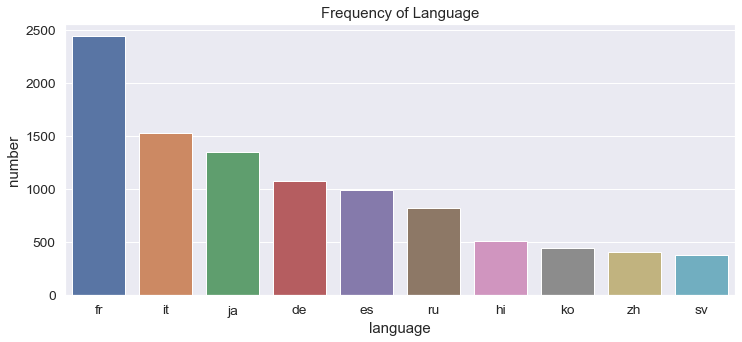

In [260]:
plt.figure(figsize=(12,5))
sns.barplot(x = 'language', y = 'number', data = lang_df.iloc[1:11])
plt.title('Frequency of Language')
plt.show()

## popularity, vote_average, vote_count
이 섹션에서는 TMDB 사용자가 제공한 지표로 작업할 것입니다. 우리는 인기, 투표 평균 및 투표 수 기능에 대해 더 깊이 이해하고 예산 및 수익과 같은 다른 숫자 기능뿐만 아니라 그들 사이의 관계를 추론하려고 노력할 것입니다.


In [261]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [262]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [263]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

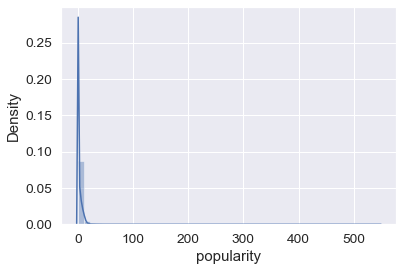

In [264]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

<AxesSubplot:ylabel='Frequency'>

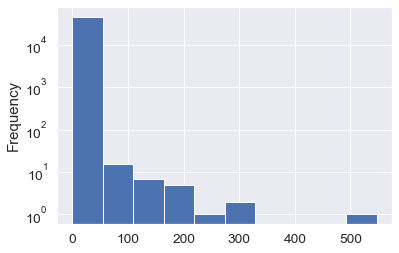

In [265]:
df['popularity'].plot(logy=True, kind = 'hist')

인기 점수는 평균이 2.9에 불과하지만 최대 값은 평균보다 거의 1800% 더 큰 547에 달하는 매우 왜곡된 정보로 보인다. 그러나, 배급 플롯에서 볼 수 있듯이, 거의 모든 영화는 인기 점수가 10점 미만이다(75번째 백분위수는 3.678902이다).

### 인기 점수에 의한 가장 인기있는 영화

In [266]:
df[['title', 'popularity','year']].sort_values('popularity', ascending = False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [267]:
df['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

 인기 점수와 마찬가지로 vote_count는 평균이 10표, 최댓값이 14,075표로 무척 왜곡되어 있다. 따라서 TMDB 투표는 IMDB에 비해 신뢰성이 낮다고 할 수 있다. 그렇지만 웹사이트에서 가장 많은 투표를 받은 영화를 알아보도록 하자.

### 득표수가 높은 영화

In [268]:
df[['title','vote_count','year']].sort_values('vote_count', ascending = False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [269]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

<AxesSubplot:xlabel='vote_average', ylabel='Density'>

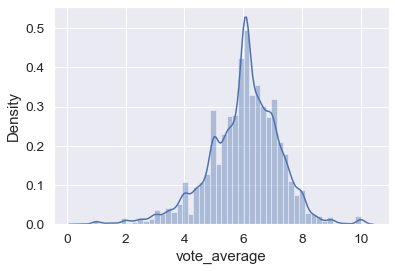

In [270]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

TMDB 사용자는 등급이 매우 엄격한 것으로 보인다. 평균 등급은 10의 척도에서 5.6에 불과하다. 영화의 절반은 평점이 6점 이하이다. TMDB에 따라 가장 비평가들의 찬사를 받은 영화가 무엇인지 확인해 봅시다. 우리는 2000표 이상의 표가 있는 영화만 고려할 것이다(IMDB의 상위 250개를 선택할 때 5000표 기준과 유사).

### 비평가들에게 찬사를 받은 영화


In [271]:
df[df['vote_count'] > 2000][['title', 'vote_average','vote_count','year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


인기와 평균 득표수 수치 사이에 양의 상관관계가 있는지 산점도의 형태로 알아보도록 한다. 

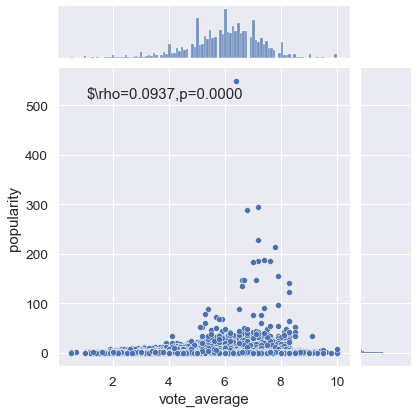

In [272]:
j = sns.jointplot(x='vote_average', y='popularity', data=df)
r, p = stats.pearsonr(df['vote_average'].fillna(df['vote_average'].median()), df['popularity'].fillna(df['popularity'].median()))
j.ax_joint.annotate(f'$\\rho={r:.4f},p={p:.4f}', xy=(0.1,0.9), xycoords = 'axes fraction')
plt.show()

놀랍게도, 앞서 언급한 두 양의 피어슨 계수는 가시적인 상관관계가 없다는 것을 시사하는 0.097이다. 즉, 인기와 투표 평균과 독립적인 수치이다. TMDB가 영화에 수치 인기 점수를 어떻게 할당하는지 발견하는 것은 흥미로울 것이다.

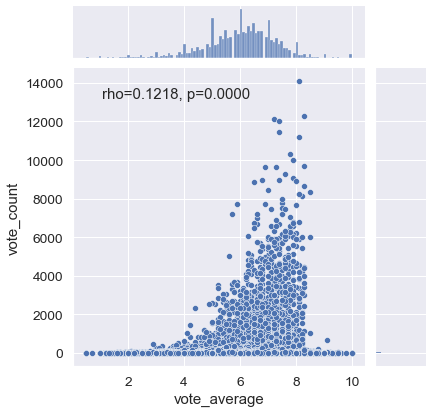

In [273]:
j = sns.jointplot(x= 'vote_average', y = 'vote_count', data = df)
r, p = stats.pearsonr(df['vote_average'].fillna(df['vote_average'].median()), df['vote_count'].fillna(df['vote_count'].median()))
j.ax_joint.annotate(f'rho={r:.4f}, p={p:.4f}', xy=(0.1, 0.9), xycoords = 'axes fraction')
plt.show()

vote_counut와 vote_average는 무척 작은 상관관계를 가지고 있으며, 이는 표를 많이 받은 영화가 반드시 좋은 영화라는 것을 의미하지 않는다.

## Movie Release Dates
개봉일은 영화의 성공과 수익을 결정하는데 매우 중요한 역할을 할 수 있다. 이번 섹션에서는 년, 월, 일 측면에서 통찰력을 얻기위해 노력할 것이다.  

우리는 이미 예비 데이터 랭글리 단계에서 **year**변수를 구했으므로 월, 일에 대해 알아보도록 하자.

In [274]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [275]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) -1]
    except:
        return np.nan

In [276]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [277]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

이제 가장 성공적인 월과 일을 알아보도록 하자.

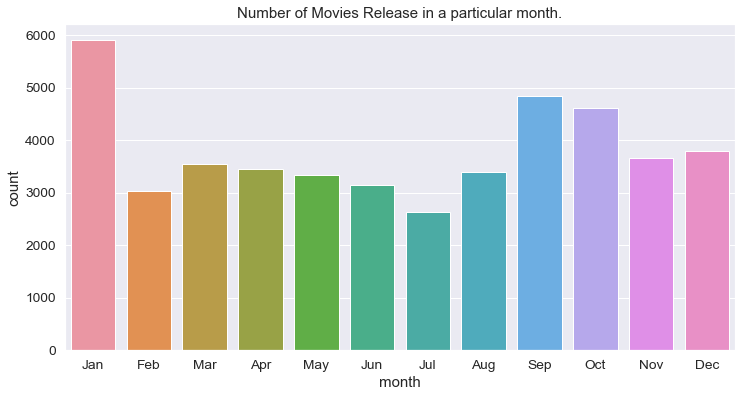

In [278]:
plt.figure(figsize=(12,6))
plt.title('Number of Movies Release in a particular month.')
sns.countplot(x = 'month', data = df, order = month_order)
plt.show()

영화 개봉과 관련하여 1월이 가장 인기 있는 달인 것 같다. 할리우드 서클에서, 이것은 하위 파 영화가 12편이 개봉하는 덤프의 달로도 알려져 있다.

어떤 달에 복버스터 영화가 개봉하는 경향이 있나요? 이 질문에 답하기 위해, 우리는 1억 달러를 초과하는 모든 영화를 고려하고 매달 평균 총액을 계산할 것이다.

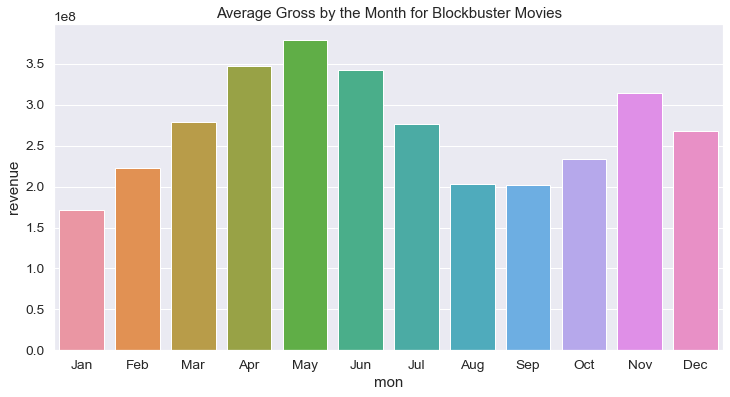

In [279]:
month_mean = pd.DataFrame(df[df['revenue']>1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title('Average Gross by the Month for Blockbuster Movies')
sns.barplot(x = 'mon', y = 'revenue', data = month_mean, order=month_order)
plt.show()

우리는 4월, 5월, 6월의 달이 높은 수익을 올리는 영화 중 평균 총생산이 가장 높다는 것을 알 수 있다. 이것은 블록버스터 영화가 보통 아이들이 학교에 다니지 않는 여름에 개봉되므로 관객들이 가처분 수입을 엔터테인먼트에 쓸 가능성이 더 높다는 사실에 기인할 수 있다.

어떤 달은 다른 달보다 더 성공적인 경향이 있는지 return 과 month 사이의 박스플롯을 시각화해 봅시다.

(0.0, 12.0)

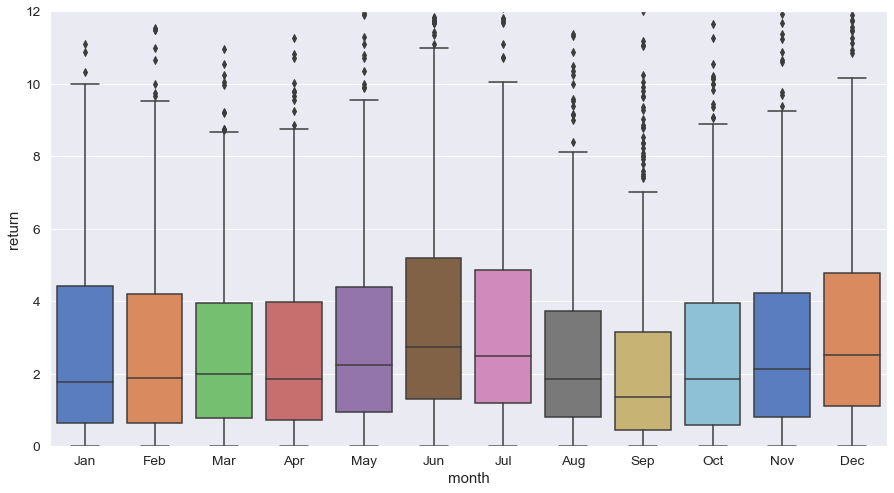

In [280]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,8))
sns.boxplot(x='month', y='return', data=df[df['return'].notnull()], palette='muted', ax=ax, order=month_order)
ax.set_ylim([0,12])

6월과 7월의 달은 가장 높은 중간 수익률을 내는 경향이 있다. 9월은 앞서 언급한 지표에서 가장 성공적이지 않은 달이다. 다시 말하지만, 6월과 7월 영화의 성공은 그들이 여름철과 휴가 시간 때문일 수 있다. 9월은 보통 학교/대학 학기의 시작을 나타내므로 영화 소비를 약간 줄인다.

이제 몇 달 동안 그랬던 것처럼 가장 인기 있는 날들을 살펴봅시다. 

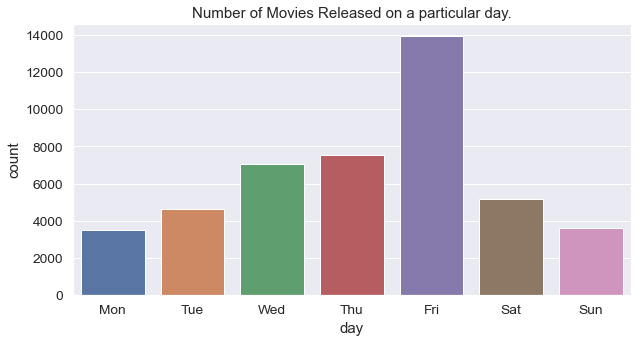

In [281]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies Released on a particular day.")
sns.countplot(x='day', data= df, order=day_order)
plt.show()

금요일은 분명히 영화 개봉에서 가장 인기 있는 날이다. 이것은 보통 주말의 시작을 나타내고 있다는 사실을 고려할 때 이해할 수 있다. 일요일과 월요일은 가장 인기 없는 날이며 이것은 앞서 언급한 것과 같은 이유에 기인할 수 있다.

### 연도별 영화 수 
우리가 이용할 수 있는 45,000편의 영화 데이터셋은 영화가 시작된 이래로 개봉된 영화의 전체 코퍼스를 대표하지 않는다. 그러나, 할리우드에서 개봉된 거의 모든 주요 영화뿐만 아니라 전 세계의 다른 주요 영화 산업(인도의 볼리우드와 같은)을 포함한다고 가정할 수 있다. 이 가정을 염두에 두고, 올해 제작된 영화의 수를 살펴봅시다.

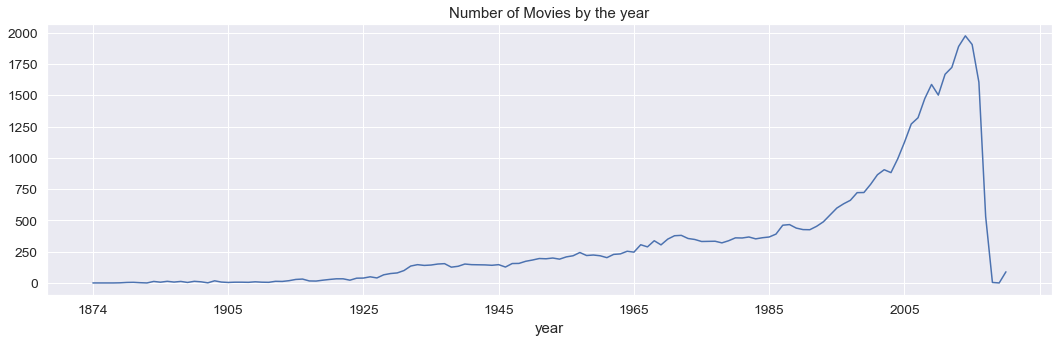

In [282]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
plt.title('Number of Movies by the year')
year_count.plot()
plt.show()

우리는 1990년대 10년대를 시작하는 영화의 수가 급격히 증가하고 있다는 것을 알아차렸다. 그러나, 우리는 최근 영화가 이 데이터셋의 목적을 위해 오버샘플링되었을 가능성이 있기 때문에 이것을 너무 많이 조사하지 않을 것이다.

다음으로, 데이터셋에 표현된 가장 초기의 영화를 살펴봅시다.

### 초기 영화 대표작

In [283]:
df[df['year'] != 'NaT'][['title','year']].sort_values('year').head(10)

,title,year
34940,Passage of Venus,1874
34937,Sallie Gardner at a Gallop,1878
41602,Buffalo Running,1883
34933,Man Walking Around a Corner,1887
34934,Accordion Player,1888
34938,Traffic Crossing Leeds Bridge,1888
34936,"Monkeyshines, No. 2",1890
34939,London's Trafalgar Square,1890
34935,"Monkeyshines, No. 1",1890
41194,Mosquinha,1890


가장 오래된 영화인 금성의 통로는 1874년에 태양을 가로지르는 금성의 통과에 대한 일련의 사진을 찍었다. 그들은 프랑스 천문학자 피에르 얀센이 그의 '사진 리볼버'를 사용하여 일본에서 촬영되었다. 이것은 또한 IMDB와 TMDB 모두에서 가장 오래된 영화이다.

마지막으로, 이 섹션에서, 금세기에 개봉된 모든 영화에 대해 월과 연도별 영화 개봉을 나타내는 히트맵을 구성해 봅시다. 이것은 우리에게 영화광들에게 열정적이고 냉소적인 달에 대한 좋은 아이디어를 줄 것이다.

In [284]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [285]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >= 2000]

hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values = 'title')
hmap_21 = hmap_21.fillna(0)

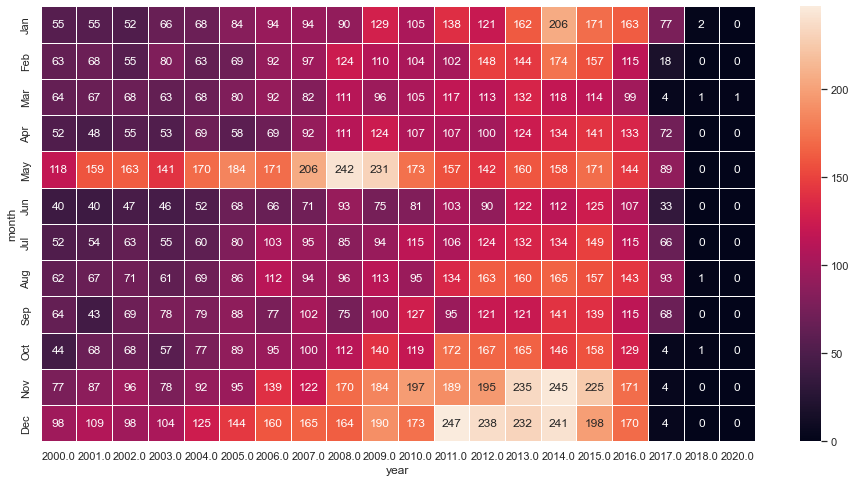

In [286]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)
sns.set(font_scale=1.25)
plt.show()

## Movie status
영화 분석과 완전히 관련이 있는 것은 아니지만, 개봉 상태에 따라 다양한 종류의 영화에 대한 정보를 수집하면 데이터 세트에 존재하는 영화의 본질에 대한 통찰력을 제공할 수 있습니다. 내 예비 직감은 거의 모든 영화가 개봉 상태를 가지고 있다는 것이었다. 알아보자.

In [287]:
df['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

거의 모든 영화가 실제로 개봉된다. 그러나, MovieLens가 아직 계획, 제작 및 포스트 프로덕션 단계에 있는 영화에 대한 사용자 등급을 가지고 있다는 것을 보는 것은 흥미롭다. 우리는 협업 필터링 추천 엔진을 구축하는 동안 이 정보를 고려할 수 있습니다.

## Spoken Languages
해당 변수를 통해 영화에서 사용되는 언어의 수를 숫자로 변환활 것이다. 사용된 언어의 수가 영화 성공에 영향을 미치는지 확인해보자.

In [288]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x : len(x) if isinstance(x, list) else np.nan)

In [289]:
df['spoken_languages'].value_counts()

1     33736
2      5371
0      3835
3      1705
4       550
5       178
6        62
7        14
8         6
9         5
10        1
12        1
19        1
13        1
Name: spoken_languages, dtype: int64

위 결과에서 알 수 있듯 대부분의 영화는 단일 언어만 사용하며, 가장 많은 언어를 사용한 것은 19개인 것을 알 수 있다.  
10개 이상의 언어를 사용한 영화들을 알아보자.

In [290]:
df[df['spoken_languages'] >= 10][['title','year','spoken_languages']].sort_values('spoken_languages', ascending=False)

,title,year,spoken_languages
22235,Visions of Europe,2004,19
35288,The Testaments,2000,13
14093,To Each His Own Cinema,2007,12
8789,The Adventures of Picasso,1978,10


In [291]:
## 생략(상관관계 없음)
# j = sns.jointplot(x= 'spoken_languages', y = 'return', data = df)
# r, p = stats.pearsonr(df['spoken_languages'].fillna(df['spoken_languages'].median()), df['return'].fillna(df['return'].median()))
# j.ax_joint.annotate(f'rho={r:.4f}, p={p:.4f}', xy=(0.1, 0.9), xycoords = 'axes fraction')
# plt.show()

## Runtime
이번 장에서는 영화 상영 시간에 따른 통찰을 얻고자 한다.

In [292]:
df['runtime'].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

영화 상영시간은 평균 95분이며, 상영 시간이 가장 긴 영화는 1256분인 것을 알 수 있다.

In [293]:
df['runtime'] = df['runtime'].astype('float')

우리는 영화 상영 시간이 대체로 5시간 미만임을 알 수 있다. 이를 바탕으로 시각화해보자.

<AxesSubplot:xlabel='runtime', ylabel='Density'>

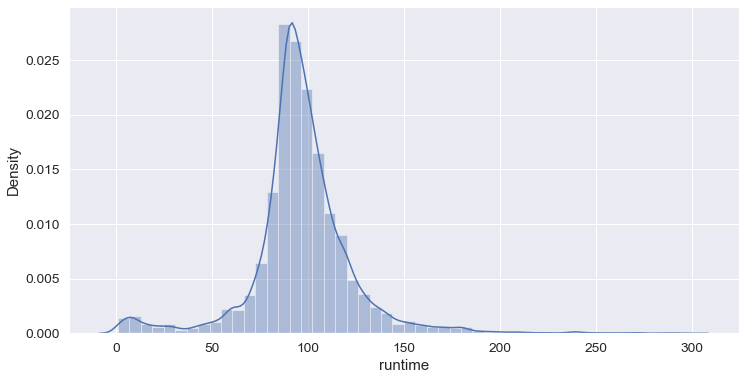

In [294]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime']<300) * (df['runtime']>0)]['runtime'])

상영시간과 return 사이에 관계가 있는지 알아보도록 하자!

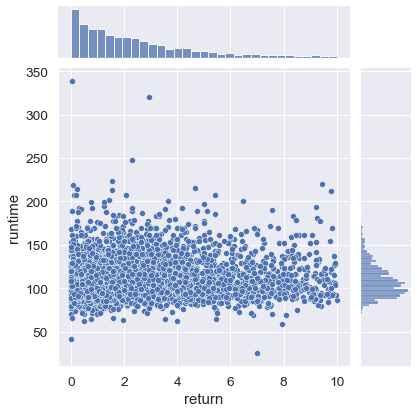

In [295]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return']<10)]
sns.jointplot('return','runtime', data=df_mat)
plt.show()

위 그래프는 양적 변수간 관계를 볼 수 있다. 영화 상영 시간과 흥행은 무관한 것으로 보인다.  
그러나 기간과 예산은 그렇지 않다고 볼 수 있을 것이다. 영화가 길수록 예산이 많이 필요한지 확인해보자.

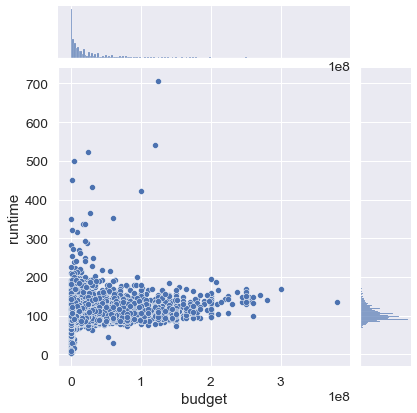

In [296]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', data = df_mat)
plt.show()

영화 상영 시간과 예산은 생각보다 훨씬 약한 상관관계를 가지고 있다. 영화의 장르는 예산에 훨씬 영향을 미친다고 볼 수 있다.
예를 들어 3시간 짜리 예술 영화는 90분 가량의 공상과학 영화보다 훨씬 저렴하다. 

다음으로 1890년대부터 2017년까지 영화 평균 길이를 알아보도록 한다.  
영화 상영 시간의 추이는 아래 그래프와 같다. 

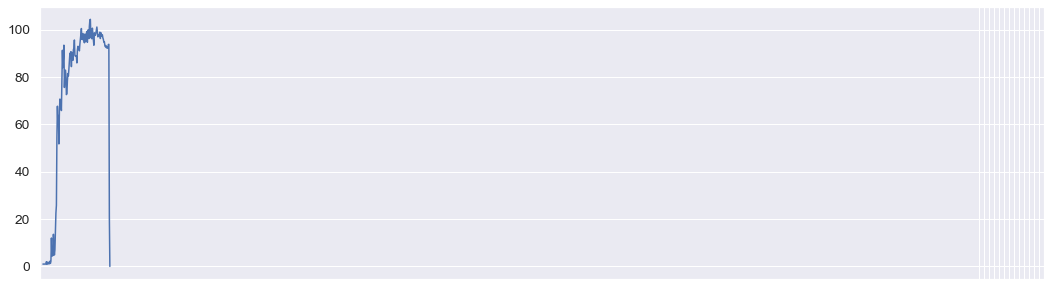

In [297]:
plt.figure(figsize=(18,5))
year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
plt.plot(year_runtime.index, year_runtime)
plt.xticks(np.arange(1874, 2014, 10.0))
plt.show()

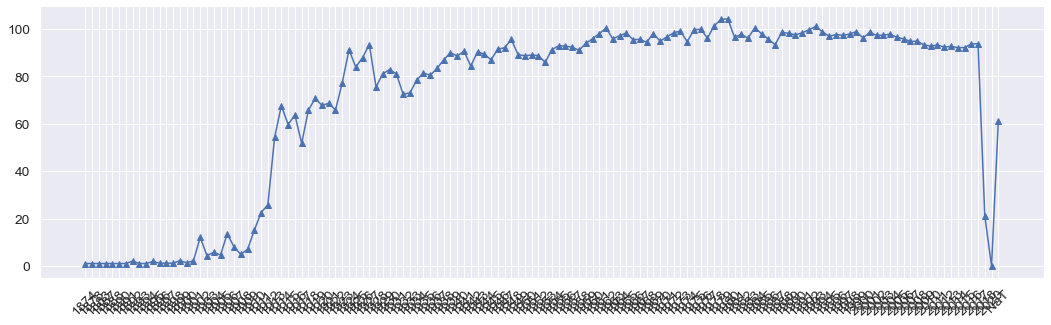

In [298]:
plt.figure(figsize=(18,5))
year_runtime = df[df['year'] != 'NaN'].groupby('year')['runtime'].mean()
plt.plot(year_runtime.index, year_runtime, marker='^')
# plt.xticks(np.arange(1874, 2024, 10.0), fontsize=20, rotation=45)
plt.xticks(label = np.arange(1874, 2024, 10), rotation=45)
plt.show()

위 그래프를 통해 1914년부터는 상영시간이 60분 이후(1924년)부터는 90분동안 지속되었으며 큰 변동사항은 없었다. 

마지막으로 역대 가장 길고 짧은 영화를 보겠다.

### Shortest Movies

In [299]:
df[df['runtime'] > 0][['runtime','title','year']].sort_values('runtime').head(10)

,runtime,title,year
35146,1.0,La Vague,1891
36577,1.0,Champs de Mars,1900
36576,1.0,Palace of Electricity,1900
44965,1.0,"Luis Martinetti, Contortionist",1894
42357,1.0,A Gathering of Cats,2007
36575,1.0,Eiffel Tower from Trocadero Palace,1900
36574,1.0,Panorama of Eiffel Tower,1900
44714,1.0,The Infernal Caldron,1903
19244,1.0,The Kiss,1896
44646,1.0,The Vanishing Lady,1896


위 목록의 모든 영화는 1분 짜리이며 '고양이의 모임'을 제외한 모든 영화는 1890년대 후반에서 20세기 초에 촬영되었다는 것을 알 수 있다. 

### Longest Movies

In [300]:
df[df['runtime']>0][['runtime','title','year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
24178,1256.0,Centennial,1978
40938,1140.0,Baseball,1994
19965,1140.0,Jazz,2001
13767,931.0,Berlin Alexanderplatz,1980
13953,925.0,Heimat: A Chronicle of Germany,1984
27855,900.0,The Story of Film: An Odyssey,2011
26682,877.0,Taken,2002
19158,874.0,The War,2007
34667,840.0,The Roosevelts: An Intimate History,2014
34732,840.0,Seventeen Moments in Spring,1973


위 차트의 대부분 영화는 미니시리즈이기때문에 장편 영화로 볼 수 없으며 그렇기에 가장 긴 영화 목록에서 많은 정보를 알 수 없다.

## Budget
---
위 변수는 예산이 편중되어 있고 인플레이션의 영향을 많이 받을 것으로 예상한다. 그럼에도 영화 수익과 성공을 예측하는데 있어 예산이 종종 중요한 특징이 되기 때문에 해당 변수에서 가능한 많은 통찰력을 모으도록 하자.  
우선 예약에 대한 요약 통계를 수집한다.

In [301]:
df['budget'].describe()

count    8.890000e+03
mean     2.160428e+07
std      3.431063e+07
min      1.000000e+00
25%      2.000000e+06
50%      8.000000e+06
75%      2.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

영화 평균 예산은 2160만 달러인데 반해 중간 예산은 800만 달러로 훨씬 적다.  
이는 평균이 이상치의 영향을 받는다는 것을 강하게 시사한다. 

<AxesSubplot:xlabel='budget', ylabel='Density'>

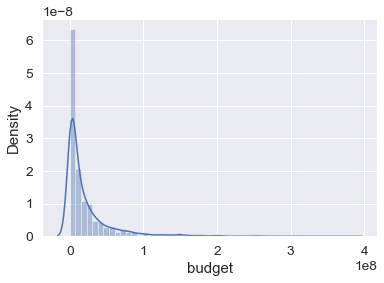

In [302]:
sns.distplot(df[df['budget'].notnull()]['budget'])

<AxesSubplot:ylabel='Frequency'>

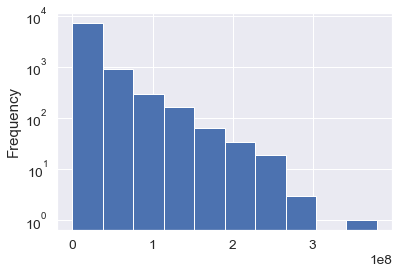

In [303]:
df['budget'].plot(logy=True, kind='hist')

영화 예산 분배는 기하급수적인 감소를 보여준다. 영화의 75% 이상이 2500만 달러 미만의 예산을 가지고 있다.  
다음으로 역대 가장 비싼 영화와 창출한 수익에 대해 살펴본다. 

### Most Espensive Movies of all Time

In [304]:
df[df['budget'].notnull()][['title','budget','revenue','return','year']].sort_values('budget', ascending = False).head(10)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
18685,John Carter,260000000.0,2.841391e+08,1.092843,2012
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
21175,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013
22059,The Hobbit: The Desolation of Smaug,250000000.0,9.584000e+08,3.833600,2013


캐리비안의 해적 영화 두 편이 3억 달러가 넘는 예산으로 이 목록의 1위를 차지했다. 가장 비싼 영화 10편 중 론 레인저를 제외, 투자 수익을 올렸다. 

예산과 수익의 상관관계가 어느정도인지 알아보자.  
(상관관계가 강할수록 예측이 더 정확해진다.)

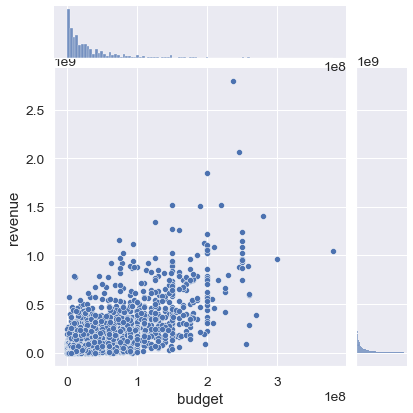

In [305]:
sns.jointplot(x='budget', y='revenue', data=df[df['return'].notnull()])

두 수치형 변수 사이의 피어슨 r값이 0.73이며 매우 강한 상관 관계를 나타낸다.

## Revenue
---
마지막으로 수익에 대해 알아보겠다. 수익은 아마도 영화와 관련된 가장 중요한 수치일 것이다. 이후 섹션에서 일련의 변수들을 통해 영화의 수익을 예측하려한다. 세입의 처리는 예산과 매우 비슷할 것이고, 우리는 다시 요약 통계를 연구하는 것으로 시작할 것이다. 

In [306]:
df['revenue'].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

영화 평균 총수입은 6870만 달러인데 반해 중앙값은 1680만 달러로 훨씬 낮아 수익의 편중성을 시사한다.   
영화가 창출한 최처 수익은 1달러에 불과한 반면, 역대 최고 수익 영화는 27억 8천만 달러의 놀라운 수익을 올렸다.

<AxesSubplot:xlabel='revenue', ylabel='Density'>

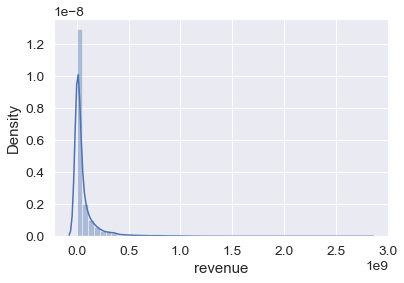

In [307]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])

수익 분배는 예산과 마찬가지로 기하급수적으로 감소한다. 또한 두 변수가 강한 양의 상관관계를 가지고 있는 것을 발견했다.  
이제 역대 최저/최고 흥행작들을 보도록 하자.

### Highest Grossing Films of All Time

In [308]:
gross_top = df[['poster_path','title','budget','revenue','year']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,poster_path,title,budget,revenue,year
14551,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,237000000.0,2.787965e+09,2009
26555,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
1639,/kHXEpyfl6zqn8a6YuozZUujufXf.jpg,Titanic,200000000.0,1.845034e+09,1997
17818,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,The Avengers,220000000.0,1.519558e+09,2012
25084,/jjBgi2r5cRt36xF6iNUEhzscEcb.jpg,Jurassic World,150000000.0,1.513529e+09,2015
28830,/dCgm7efXDmiABSdWDHBDBx2jwmn.jpg,Furious 7,190000000.0,1.506249e+09,2015
26558,/t90Y3G8UGQp0f0DrP60wRu9gfrH.jpg,Avengers: Age of Ultron,280000000.0,1.405404e+09,2015
17437,/fTplI1NCSuEDP4ITLcTps739fcC.jpg,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.342000e+09,2011
22110,/jIjdFXKUNtdf1bwqMrhearpyjMj.jpg,Frozen,150000000.0,1.274219e+09,2013
42222,/tWqifoYuwLETmmasnGHO7xBjEtt.jpg,Beauty and the Beast,160000000.0,1.262886e+09,2017


In [309]:
pd.set_option('display.max_colwidth', 50)

이 수치들은 인플레이션을 위해 조정되지 않았다. 따라서 우리는 최근 10위권 안에 있는 영화들의 수가 불균형적으로 많다. 영화를 통해 얻은 수익을 이해하기 위해 연간 최대 수익을 표시해 보겠다.

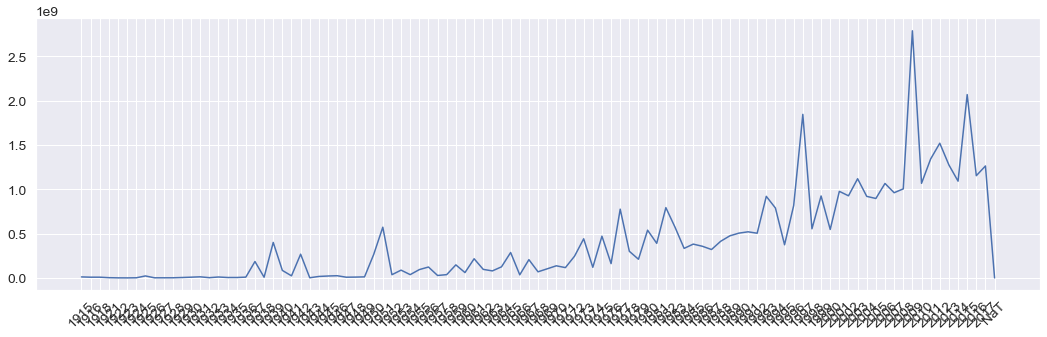

In [310]:
plt.figure(figsize=(18,5))
year_revenue = df[(df['revenue'].notnull()) & (df['year'] != 'NaN')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(label = np.arange(1874, 2024, 10), rotation=45)
plt.show()

이 수치에서 알 수 있듯, 최대 총액은 수년간 꾸준히 증가했으며 타이타닉 개봉으로 1997년 10억 달러를 돌파했다.  
아바타는 20억 달러를 돌파하는데 12년이 더 걸렸으며, 이 두 영화 모두 제임스 카메론이 감독했다.

## Returns
---
영화 역사상 가장 성공적인 영화와 그렇지 못한 영화를 확인해보도록 하자. 이를 위해 예산 500만 달러 이상의 영화만 검토하겠다.

In [311]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title','budget','revenue','return','year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
256,Star Wars,11000000.0,775398007.0,70.490728,1977
1338,Jaws,7000000.0,470654000.0,67.236286,1975
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
834,The Godfather,6000000.0,245066411.0,40.844402,1972
4492,Look Who's Talking,7500000.0,296000000.0,39.466667,1989
24258,Annabelle,6500000.0,255273813.0,39.272894,2014
1056,Dirty Dancing,6000000.0,213954274.0,35.659046,1987
1006,The Sound of Music,8200000.0,286214286.0,34.904181,1965


### Worst Box Office Disasters

In [312]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue']>10000)][['title','budget','revenue','return','year']].sort_values('return').head(10)

,title,budget,revenue,return,year
11159,Chaos,20000000.0,10289.0,0.000514,2005
19027,5 Days of War,20000000.0,17479.0,0.000874,2011
21034,Special Forces,10000000.0,10759.0,0.001076,2011
25732,Foodfight!,65000000.0,73706.0,0.001134,2012
38388,Term Life,16500000.0,21256.0,0.001288,2016
19505,Laurence Anyways,9500000.0,12250.0,0.001289,2012
12038,The Good Night,15000000.0,20380.0,0.001359,2007
3966,Cherry 2000,10000000.0,14000.0,0.001400,1987
22097,Twice Born,13000000.0,18295.0,0.001407,2012
5651,All The Queen's Men,15000000.0,23000.0,0.001533,2001


이러한 분석을 실시하면 상관 매트릭스를 구축할 수 있다.

In [313]:
df['year'] = df['year'].replace('NaT', np.nan)

In [314]:
df['year'] = df['year'].apply(clean_numeric)

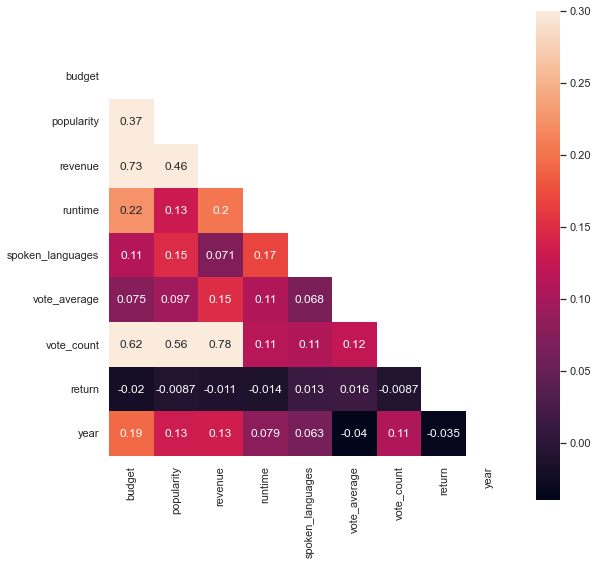

In [315]:
sns.set(font_scale=1)
corr=df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [316]:
sns.set(font_scale=1.25)

## Genres

In [317]:
test_data = df.copy

In [318]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

In [319]:
s = df.apply(lambda x :pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [320]:
gen_df = df.drop('genres', axis=1).join(s)

In [321]:
gen_df['genre'].value_counts().shape[0]

32

TMDB는 45,000편의 영화 세트에 대해 32개의 다른 장르를 정의한다. 이제 영화별 빈도를 알아보자

In [322]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre','movies']
pop_gen.head(10)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


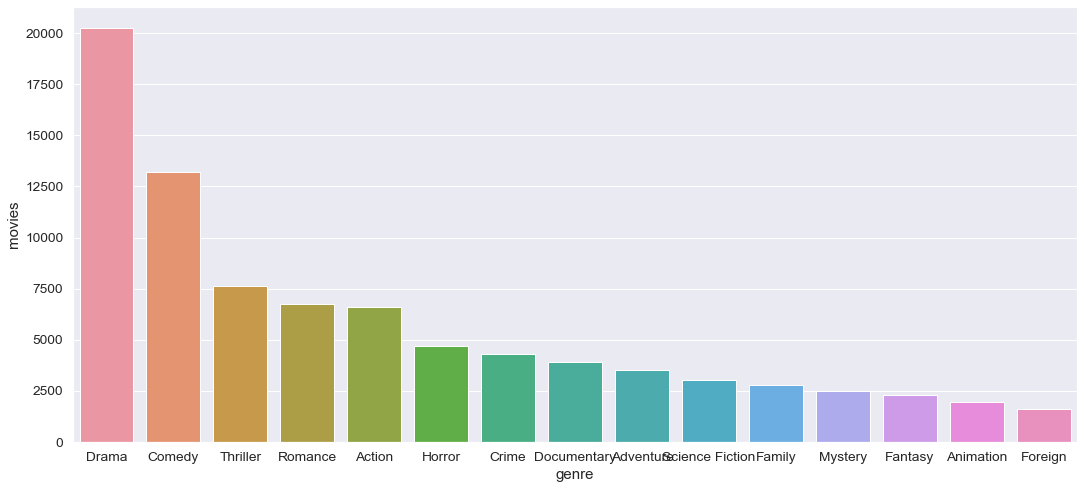

In [323]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre',y='movies',data=pop_gen.head(15))
plt.show()

**드라마**는 영화 절반의 장르라고 할 수 있을만큼 흔한 장르이다. 그 다음으로 코미디, 스릴러, 로맨스, 액션, 공포, 범죄 등의 순서이다. 

다음으로 알아볼 것은 장르별 점유율 추이이다. 공상과학 영화의 수요가 증가했는지, 애니메이션 영화의 점유율이 불균형한해도 있는지 알아보자.

(아래는 2000년 이후 동향만 살펴보도록 한다. 가장 인기 있는 장르 15위 까지만 검토할 것이며, 다큐멘터리와 가족, 외국 영화는 분석 대상에서 제외한다.)

In [324]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 
          'Crime', 'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

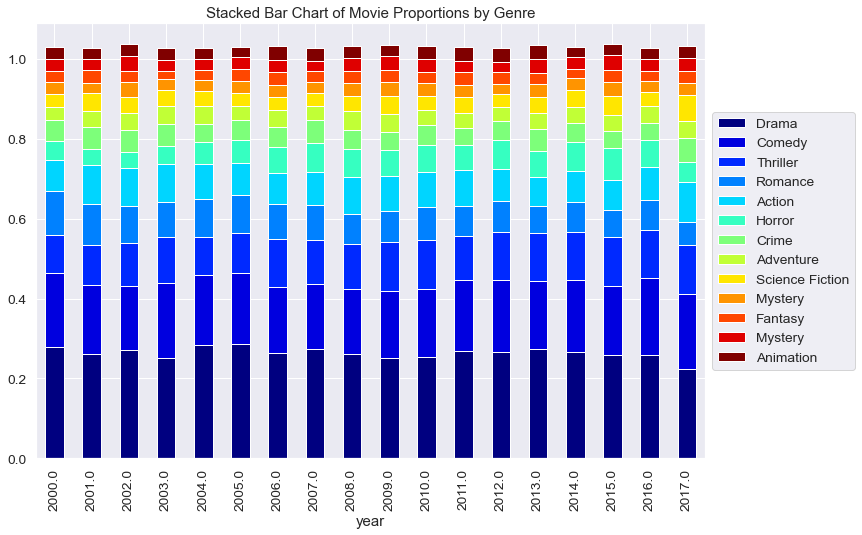

In [325]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres)) & (gen_df['year'] >= 2000) & (gen_df['year']<=2017)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x : x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked = True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Stacked Bar Chart of Movie Proportions by Genre')
plt.show()

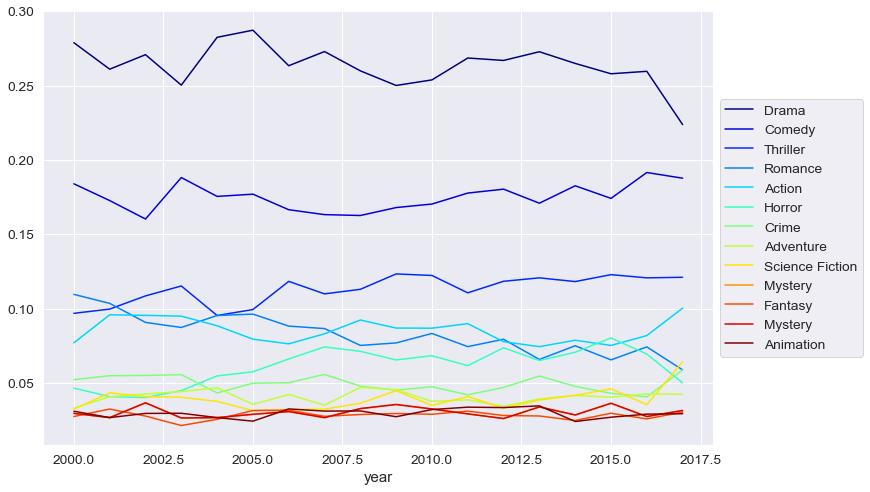

In [326]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

21세기 초부터 드라마를 제외한 장르별 영화 비중은 일정한 것을 알 수 있다. 드라마 영화의 비율은 5% 이상 감소했으며 스릴러 영화의 점유율이 소폭 증가했다.  

여기서 생기는 의문은 어떤 장르들이 더욱 성공적일 수 있는가이다. 예를 들어, 공상과학 영화나 판타지 영화가 다른 장르보다 더 많은 수익을 가져올 것이라고 예상할 수 있지만 예산을 정산하면 특정 장르가 성공적이라는 것이 입증될까? 우리는 이 질문에 답하기 위해 두 개의 바이올린 플롯을 시각화할 것이다. 하나는 장르대 수익이고 다른 하나는 수익 대 수익이다. 

In [327]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

<Figure size 1296x576 with 0 Axes>

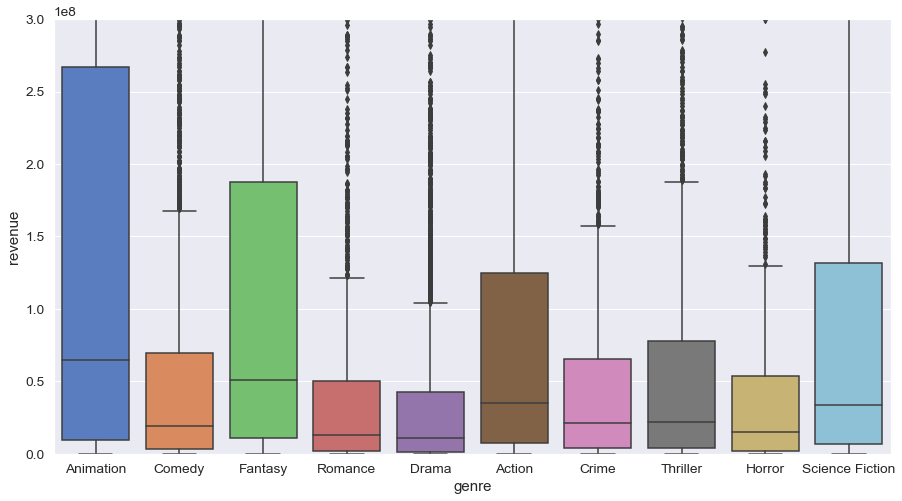

In [328]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette='muted', ax = ax)
ax.set_ylim([0,3e8])
plt.show()

**애니메이션**영화는 25-75편 중 가장 큰 범위와 중간 수익을 가지고 있다. **판타지**와 **공상과학**은 각각 두 번째, 세 번째 순위 매출을 가지고 있다. 

<Figure size 1296x576 with 0 Axes>

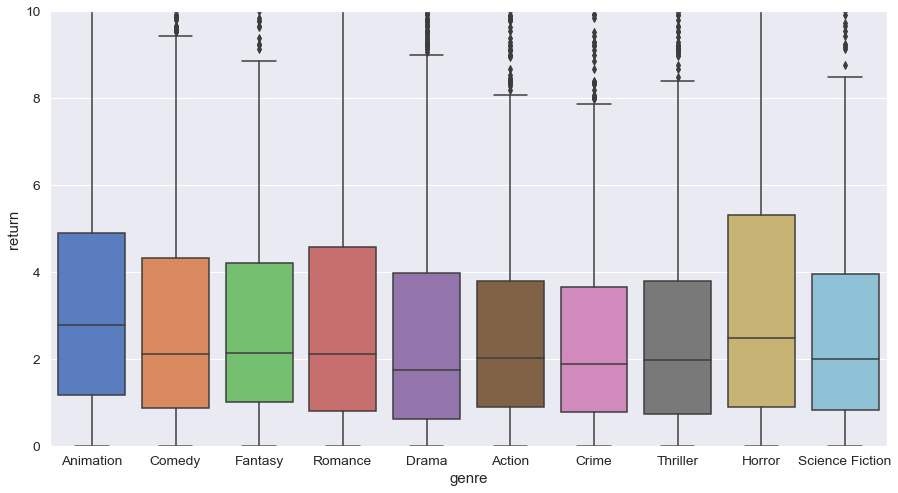

In [329]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.boxplot(x='genre', y= 'return', data=violin_movies, palette='muted', ax=ax)
ax.set_ylim([0,10])
plt.show()

박스 플롯을 보면 **애니메이션** 영화가 평균 수익률이 가장 높은것처럼 보여진다.  
**호러 무비** 또한 좋은 베팅으로 볼 수 있으며 이것은 부분적으로 판타지 영화에 비해 낮은 예산으로 높은 수익을 창출할 수 있는 호러 영화의 특성 때문이다.

# Cast and Crew (새로운 데이터)
---
이제 영화의 출연진과 제작진을 살펴보도록 하자. 메인 데이터 세트에는 이러한 세부 정보가 없다.  
하지만 모든 무비렌즈 영화의 풀 캐스팅과 크루 크레딧으로 구성된 별도의 파일을 가지고 있으니 'credit' 데이터를 살펴보도록 하자.

In [330]:
credits_df = pd.read_csv('credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


## Credits Dataset
* **cast** : 캐스팅 이름과 해당 캐릭터가 연기한 캐릭터로 구성된 사전의 문자열 목록.
* **crew** : 참여자들 이름과 수행한 기능으로 구성된 사전의 문자열 목록.
* **id** : 영화의 TMDB ID


TMDB Movie ID의 credits 데이터 프레임을 사요해 원본 동영상 메타데이터 데이터 프레임의 left join을 수행해야 한다. 
이 조인을 수행하기 전에 메인 데이터 프레임(df)의 ID열이 깨끗하고 정수형인지 확인해야 한다.  
이를 위해 ID의 정수 변환을 시도하고 예외가 발생할 경우 ID를 NaN으로 교체한다.  
그런 다음 데이터 프레임에서 해당 행을 삭제한다. 

In [331]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [332]:
df['id'] = df['id'].apply(convert_int)

In [333]:
df[df['id'].isnull()]

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,status,tagline,title,video,vote_average,vote_count,return,year,day,month
19730,0.065736,NaN,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,104.0,Released,NaN,Midnight Man,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,1.931659,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,68.0,Released,NaN,Mardock Scramble: The Third Exhaust,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2.185485,NaN,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,82.0,Released,NaN,Avalanche Sharks,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
df = df.drop([19730, 29503, 35587])

In [335]:
df['id'] = df['id'].astype('int')

In [336]:
df = df.merge(credits_df, on='id')
df.shape

(45538, 27)

In [337]:
df['cast'] = df['cast'].apply(ast.literal_eval)
df['crew'] = df['crew'].apply(ast.literal_eval)

In [338]:
df['cast_size'] = df['cast'].apply(lambda x : len(x))
df['crew_size'] = df['crew'].apply(lambda x : len(x))

In [339]:
df['cast'] = df['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [340]:
def get_director(x):
    for i in x:
        if i['job']=='Director':
            return i['name']
        return np.nan

In [341]:
df['director'] = df['crew'].apply(get_director)

In [342]:
s = df.apply(lambda x : pd.Series(x['cast']), axis=1).stack().reset_index(level=1, drop=True)
s.name='actor'
cast_df=df.drop('cast', axis=1).join(s)

이제 영화고 가장 많은 돈을 벌어들인 배우들과 감독들을 살펴보자.

## Actors with the Higest Total Revenue

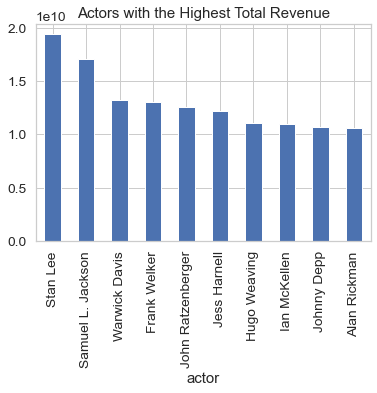

In [343]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

## Diretors with the Highest Total Revenue

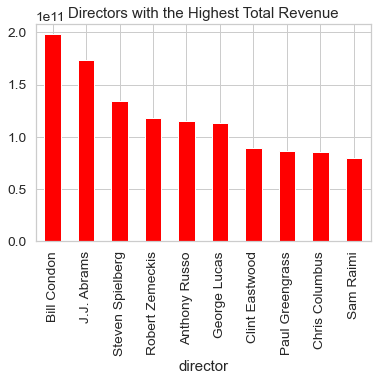

In [344]:
plt.title('Directors with the Highest Total Revenue')
cast_df.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn')
plt.show()

평균 수익은 최소 5편의 영화에 출연하고 연출한 배우와 감독만 고려하겠다. 

In [345]:
actor_list = cast_df.groupby('actor')['revenue'].count().sort_values(ascending=False)
actor_list = list(actor_list[actor_list >= 5].index)
director_list = df.groupby('director')['revenue'].count().sort_values(ascending=False)
director_list = list(director_list[director_list >= 5]. index)

## Actors with Highest Average Revenue

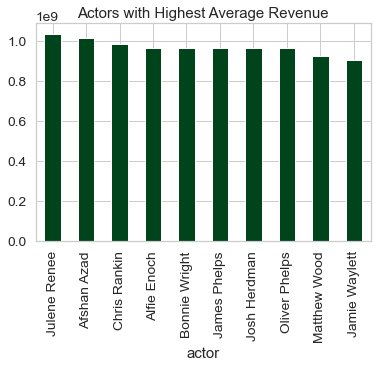

In [346]:
plt.title("Actors with Highest Average Revenue")
cast_df[cast_df['actor'].isin(actor_list)].groupby('actor')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='Greens_r')
plt.show()

## Directors with Higest Average Revenue

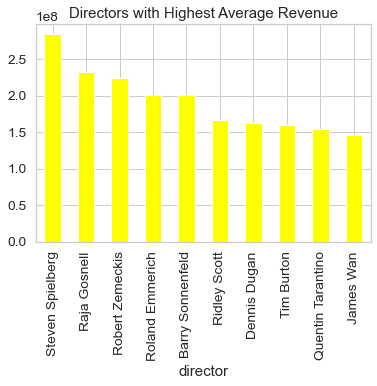

In [347]:
plt.title("Directors with Highest Average Revenue")
df[df['director'].isin(director_list)].groupby('director')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn_r')
plt.show()

어떤 배우와 감독이 가장 안전한가? 이를 위해 특정 감독이나 배우가 가져오는 평균 수익률을 고려해보겠다.  
적어도 천만 달러를 벌어들인 영화들만 검토할 것이다. 또한 최소 5편의 영화에 출연한 배우와 감독만 고려하겠다.

## Most Successful Actors

In [348]:
success_df = cast_df[(cast_df['return'].notnull()) & (cast_df['revenue'] > 1e7) & (cast_df['actor'].isin(actor_list))]
pd.DataFrame(success_df.groupby('actor')['return'].mean().sort_values(ascending=False).head(10))

,return
actor,
Jami Gertz,3.099099e+06
Donna Mitchell,2.479289e+06
Andrew McCarthy,2.479280e+06
Nicholas Pryor,1.770914e+06
James Spader,1.549551e+06
Michael Bowen,1.033038e+06
Robert Downey Jr.,5.165189e+05
Martin Kove,3.395458e+05
William Zabka,3.395441e+05


## Most Successful Directors

In [349]:
success_df = df[(df['return'].notnull()) & (df['revenue'] > 1e7) & (df['director'].isin(director_list))]
pd.DataFrame(success_df.groupby('director')['return'].mean().sort_values(ascending=False).head(10))

,return
director,
John G. Avildsen,49.996119
James Wan,30.948536
William Friedkin,27.892852
Guy Hamilton,25.779057
Alfred Hitchcock,13.998131
Steven Spielberg,13.900199
Sidney Lumet,13.401260
Michael Moore,9.871788
Quentin Tarantino,9.399225


**John G. Avildsen**은 부자연스럽게 높은 수익률을 보이고 있다. 리스트에 있는 다른 모든 이사들은 그가 얻은 수익 수준에는 전혀 미치지 못한다. 그의 영화를 봅시다.

In [350]:
df[(df['director'] == 'John G. Avildsen') & (df['return'].notnull())][['title','budget','revenue','return','year']]

,title,budget,revenue,return,year
2307,Rocky V,42000000.0,119946358.0,2.855866,1990.0
2315,The Karate Kid,8000000.0,90815558.0,11.351945,1984.0
5226,Joe,106000.0,19319254.0,182.257113,1970.0
5658,Neighbors,8500000.0,29916207.0,3.519554,1981.0


**The Karate Kid2** 예산은 113달러 밖에 되지 않는다. 공식 수치상으로 1300만 달러 (약 1천 300억원)가 들었다고 하니 이례적인 일이다. 그러므로 비록, 그가 놀라운 영화를 감독했지만, 그는 이 목록에 속하지 않는다.  

EDA는 여기서 마치고 이 섹션에서 얻은 몇 가지 통찰력을 활용해 유용한 예측 모델을 구축해보도록 하겠다. 

# Regression : Predict Movie Revenues
---
이번 장에서는 영화 수익을 예측하기 위한 회귀 모델을 구축하도록 한다.   
그러나 회귀 모델은 이 프로젝트의 주요 목적이 아니기에 피처 엔지니어링이나 매개변수 튜닝에 많은 시간은 할애하지 않을 것이다.  

영화 수익 예측은 매우 인기있는 주제이다. 이 논문에서 제안된 대부분의 모델은 현재 우리가 보유하고 있는 것보다 훨씬 강력한 기능을 사용한다. 여기에는 Facebook Page Like, 영화에 대한 트윗 정보, Youtube Trailer Reaction(보기, 좋아, 싫어 등), Movie Rating(MPCAA, CBIFC)등이 포함된다.


영화 박스 오피스 예측에 관한 프로젝트는 [여기](https://github.com/aannasw/movies-capstone)를 참조해보자


이러한 변수의 부족을 보충하기 위해, 우리는 약간의 속임수를 사용할 것이다.
TMDB의 **인기점수**와 **투표 평균**을 모델로 사용해 인기에 미묘한 가치를 부여할 것이다. 그러나 영화가 개봉되지 않은 현실에서 영화 수익을 예측할 때 이러한 지표를 사용할 수 없음을 명심하자!

In [149]:
rgf = df[df['return'].notnull()]
rgf.shape

(5393, 30)

트레이닝 세트에서는 5393개의 레코드가 있으며, 변수들을 살펴보고 불필요한 변수들은 제거하도록 한다.

In [151]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [152]:
rgf = rgf.drop(['id','overview','poster_path','release_date','status','tagline','video','return','crew'], axis=1)

다음 변수 엔지니어링 작업을 수행한다. 
1. **belongs_to_collection** 
 - Boolean 변수로 변환한다. 1은 영화가 컬렉션의 일부임을 나타내고 0은 그렇지 않음을 나타낸다.
2. **genres**
 - 여러 장르로 변환한다. 
3. **homepage**
 - 영화의 홈페이지가 있는지 없는지를 Boolean 변수로 변환
4. **original_language**
 - 특정 영화가 영어인지 외국어인지를 나타내는 is_foreign이라는 변수로 대체한다. 
5. **production_companies**
 - 특정 영화를 만들기 위해 협력하는 제작사 수로 대체된다.
6. **production_countries**
 - 영화가 촬영된 국가의 수로 대체된다.
7. **day** 
 - 영화가 금요일에 개봉되었는지 여부를 이진 변수로 나타낸다.
8. **month** 
 - 휴가철이였는지 여부를 나타내는 변수로 변환.

In [153]:
s = rgf.apply(lambda x : pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_rgf = rgf.drop('genres', axis=1).join(s)
genres_train = gen_rgf['genre'].drop_duplicates()

## feature_engineering

In [186]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x:0 if x == np.nan else 1)
    for genre in genres_train:
        df['is_' +str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x : len(x))
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x : 1 if x =='en' else 0)
    df = df.drop('original_language', axis=1)
    
    df['production_companies'] = df['production_companies'].apply(lambda x : len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x : len(x))
    df['is_Friday'] = df['day'].apply(lambda x : 1 if x == 'Fri' else 0)
    df = df.drop('day', axis=1)
    
    df['is_Holiday'] = df['month'].apply(lambda x : 1 if x in ['Apr','May','Jun','Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title','cast','director'], axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [187]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [188]:
X = feature_engineering(X)

In [189]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [190]:
X.shape

(5393, 38)

In [191]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.7470157839629036

회귀 모델에서 **0.80**의 결정 계수를 얻었는데 이는 기본 모델에 대해 꽤 좋은 점수이다.  
이 모델 점수를 Dummy Regressor와 비교해 보자.

In [192]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

-0.0005572943904696981

우리 모델이 더비 모형보다 훨씬 더 뛰어난 성능을 발휘한다는 것을 알 수 있다.  
마지막으로 예측에서 가장 중요한 변수를 추론하기 위해 막대 플롯의 형태로 변수의 중요성을 알아본다.

## 변수별 중요도

<AxesSubplot:>

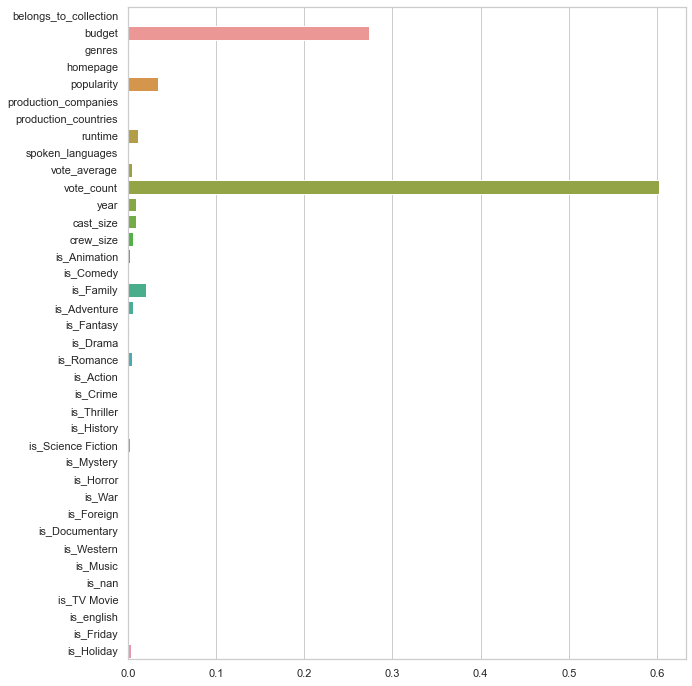

In [193]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x = reg.feature_importances_, y = X.columns)

속임수 변수인 **vote_count**가 GBM에서 가장 중요한 변수임을 알 수 있다.  
이는 계속해서 영화의 수익을 결정하는 인기 지표의 중요성을 보여준다.  **Budget**은 두 번째로 중요한 변수였고, 그 다음으로 **인기**(문자 그대로 인기 지표)와 **Crew Size**였다. 

# Classifcation : Predicting Movie Sucess
---
영화가 투자금을 회수할 수 있을지에 영향을 미치는 요소는 무엇일까? 
이번 모델은 영화가 이익을 낼지 손해를 볼지 예측하는 2진 분류기를 만들어 지 질문에 대답하기 위해 노력할 것이다.  
회귀 모델과 마찬가지로 다른 유용한 인기 지표가 없기 때문에 현실에서 사용할 수 없는 변수를 사용해 약간의 속임수를 사용하려고 한다.


우리는 이미 데이터에 대한 광범위한 분석을 수행했지만, 영화를 성공으로 이끄는 요소들에 대해 많은 것을 하지는 않았다.  
이 섹션에서는 이를 시도하고 모델을 구축해 후속 조치를 취할 것 이다. 

In [351]:
cls = df[df['return'].notnull()]
cls.shape

(5393, 30)

In [352]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [353]:
cls = cls.drop(['id','overview','poster_path','release_date','status','tagline','revenue'], axis=1)

**return** 변수를 클래스로 사용할 이진 변수로 변환한다. 0은 플롭을, 1은 히트를 나타낸다. 

In [354]:
cls['return'] = cls['return'].apply(lambda x : 1 if x >= 1 else 0)

In [355]:
cls['return'].value_counts()

1    3784
0    1609
Name: return, dtype: int64

우리 클래스는 균형이 꽤 잡힌 것 같다.  클래스의 불균형에 대처하기 위해 추가적인 방법을 적용할 필요가 없다.  
이제 우리의 변수에 주목해보자. 

In [356]:
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x : 0 if x == '' else 1)

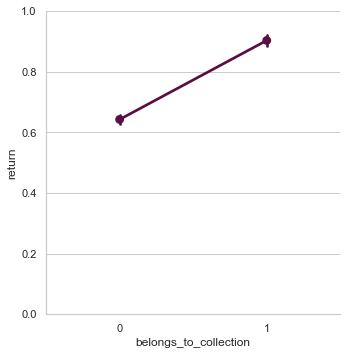

In [357]:
sns.set(style='whitegrid')
g = sns.PairGrid(data=cls, x_vars = ['belongs_to_collection'], y_vars='return', size=5)
g.map(sns.pointplot, color = sns.xkcd_rgb['plum'])
g.set(ylim=(0,1))

프렌차이즈에 속하는 영화는 성공할 확률이 더 높은 것 같다.

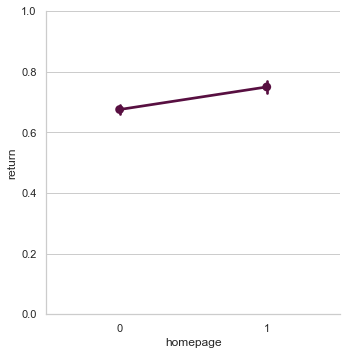

In [358]:
cls['homepage'] = cls['homepage'].fillna('').apply(lambda x : 0 if x =='' else 1)
g = sns.PairGrid(data = cls, x_vars=['homepage'], y_vars='return', size=5)
g.map(sns.pointplot, color = sns.xkcd_rgb['plum'])
g.set(ylim=(0,1))

홈페이지는 크게 영향을 미치지 않는다. 그러므로 차원의 저주를 피하기 위해 해당 변수는 제외한다.

In [359]:
s = cls.apply(lambda x : pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

<AxesSubplot:xlabel='genre'>

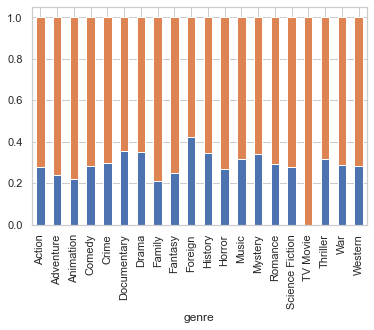

In [360]:
ctab = pd.crosstab([gen_cls['genre']], gen_cls['return'], dropna=False).apply(lambda x : x/x.sum(), axis=1)
ctab.plot(kind='bar',stacked=True, legend=False)

**TV 영화**의 에러율은 0%이지만, 이는 극소수이기 때문일 것이다.  
**외국 영화**는 평균보다 실패율이 높다. 특정 장르에 과감한 것이 없기 때문에 모든 장르를 하나의 핫 인코딩으로 진행하겠다.

In [361]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'title', 'video',
       'vote_average', 'vote_count', 'return', 'year', 'day', 'month', 'cast',
       'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

## Feature_engineering

In [362]:
def classification_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
        
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df = df.drop('homepage', axis=1)
    
    df['is_english'] = df['original_language'].apply(lambda x : 1 if x == 'en' else 0)
    df = df.drop('original_language', axis=1)
    
    df['production_companies'] = df['production_companies'].apply(lambda x : len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x : len(x))
    
    df['is_Friday'] = df['day'].apply(lambda x : 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    
    df['is_Holiday'] = df['month'].apply(lambda x : 1 if x in ['Apr','May','Jun','Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title','cast','director'], axis=1)
    # df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    df = df.drop('crew', axis=1)
    return df

In [363]:
cls = classification_engineering(cls)

In [364]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'popularity',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'video', 'vote_average', 'vote_count', 'return',
       'year', 'cast_size', 'crew_size', 'is_Animation', 'is_Comedy',
       'is_Family', 'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance',
       'is_Action', 'is_Crime', 'is_Thriller', 'is_History',
       'is_Science Fiction', 'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign',
       'is_Documentary', 'is_Western', 'is_Music', 'is_nan', 'is_TV Movie',
       'is_english', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [365]:
X, y = cls.drop('return', axis=1), cls['return']

In [366]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [367]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.787249814677539

기본 경사하강법 모델은 정확도가 **79%**이다. 하이퍼파라미터 튜닝과 고도의 엔지니어링을 통해 이 모델을 개선할 수 있으나, 프로젝트의 주요 목적이 아니므로 넘어가도록 한다.

In [368]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

0.7020014825796886

## 변수별 중요도

<AxesSubplot:>

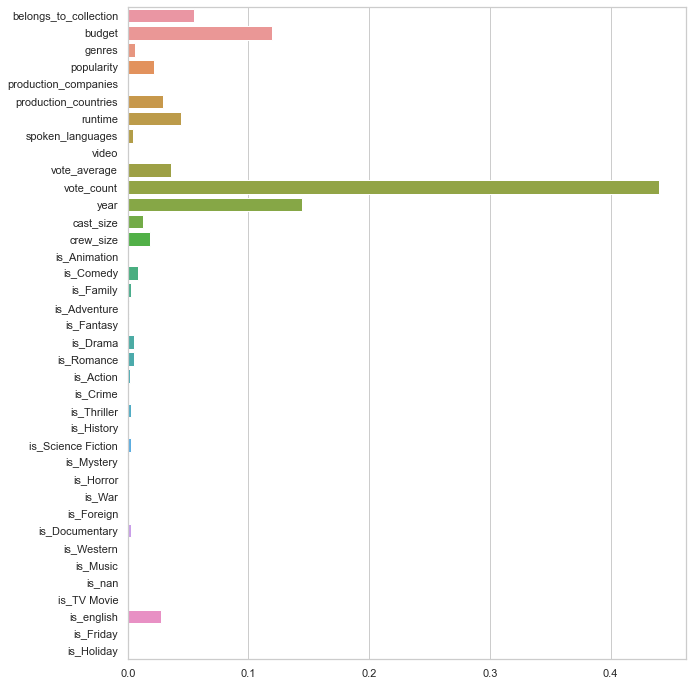

In [369]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

**Vote Count**는 다시 한 번 식별 모델에 의해 식별되는 가장 중요한 변수임을 알 수 있다.   
기타 중요한 변수로는 예산, 인기, 연도 등이 있다. 이것으로 분류 모델에 대한 논의를 마치고 프로젝트의 본론으로 넘어가도록 하자.  

다음 노트에서는 인기, 콘텐츠, 협업 필터링 기반으로 하이브리드 추천 시스템을 구축해 보겠다.  
여기서 사용한 TMDB 영화 메타데이터 외 MovieLens 데이터 세트가 사용된다.